In [6]:
import sys
import os
import yaml
import json
import numpy as np
import random
import subprocess
import torch
from matplotlib import pyplot as plt

sys.path.append('../../embeddings/')
sys.path.append('../../boshnas/')

from library import Graph, GraphLib
from boshnas import BOSHNAS
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from acq import gosh_acq as acq

In [2]:
trained_hashes = os.listdir('/scratch/gpfs/stuli/txf_design-space/models/glue/')

graphLib = GraphLib.load_from_dataset('../../dataset/dataset_test_bn.json')

def is_homogenous(graphObject):
    model_dict = graphObject.model_dict
    hashed_f = [hash(str(item)) for item in model_dict['f']]
    return True if len(set(model_dict['h'])) == 1 and len(set(model_dict['n'])) == 1 and len(set(model_dict['o'])) == 1 \
        and len(set(hashed_f)) == 1 and len(set(model_dict['p'])) == 1 else False

homogenous_models, heterogenous_models = 0, 0
X_ds_total = np.zeros((len(trained_hashes), 16))
y_ds_total = np.zeros((len(trained_hashes)))
count = 0

for model_hash in trained_hashes:
    model, _ = graphLib.get_graph(model_hash=model_hash)
    X_ds_total[count, :], y_ds_total[count] = model.embedding, \
        1 - json.load(open(f'/scratch/gpfs/stuli/txf_design-space/models/glue/{model_hash}/all_results.json'))['glue_score']
    if is_homogenous(model):
        homogenous_models += 1
    else:
        heterogenous_models += 1
    count += 1
        
print(f'Homogenous models: {homogenous_models}\nHeterogenous models: {heterogenous_models}')

Homogenous models: 12
Heterogenous models: 17


In [3]:
print(f'Best design-space performance: {1 - np.amin(y_ds_total): 0.03f}')

best_model_hash = trained_hashes[np.argmin(y_ds_total)]
best_model, _ = graphLib.get_graph(model_hash=best_model_hash)

print(f'Best model hash: {best_model_hash}')
print(f'Best model dict: {best_model.model_dict}')

print(f'Best model is homogenous: {is_homogenous(best_model)}')

homogenous_indices = [i for i in range(len(trained_hashes)) \
                       if is_homogenous(graphLib.get_graph(model_hash=trained_hashes[i])[0])]
homogenous_hashes = [trained_hashes[i] for i in homogenous_indices]
X_ds_homo, y_ds_homo = np.take(X_ds_total, homogenous_indices, axis=0), np.take(y_ds_total, homogenous_indices)

print(f'Best performance in space of homogenous models: {1 - np.amin(y_ds_homo): 0.03f}')

Best design-space performance:  0.633
Best model hash: 3043ce7b59479c89e76f539190b109ab368df128910ad7415bb232e44f975392
Best model dict: {'l': 2, 'h': [256, 256], 'n': [4, 4], 'o': ['sa', 'sa'], 'f': [[1024], [1024]], 'p': ['sdp', 'sdp']}
Best model is homogenous: True
Best performance in space of homogenous models:  0.633


In [26]:
# Implement baselines

class RandomModel():
    def __init__(self):
        pass

    def get_queries(self, x, k, **kwargs):
        return random.sample(list(range(len(x))), k)
    
    def train(self, *args, **kwargs):
        pass
    
class EvolutionaryModel():
    def __init__(self):
        self.r_cross = 0.95 # cross-over rate
        self.r_mut = 0.1 # mutation rate
        pass
    
    def get_queries(self, x, k, **kwargs):
        children = []
        while len(children) < k:
            for c in self._crossover(self.parents[0], self.parents[1]):
                children.append(self._mutation(c))
        indices = []
        for c in children:
            devs = np.mean(np.abs(c - x), axis=1)
            indices.append(np.argmin(devs))
        return list(set(indices))
    
    def train(self, X, y):
        self.parents = [X[i, :] for i in np.argsort(y)[:2]]
        
    def _crossover(self, p1, p2):
        c1, c2 = p1.copy(), p2.copy()
        if random.random() < self.r_cross:
            pt = random.randint(1, len(p1)-2)
            c1 = np.concatenate((p1[:pt], p2[pt:]))
            c2 = np.concatenate((p2[:pt], p1[pt:]))
        return [c1, c2]
    
    def _mutation(self, c):
        for i in range(len(c)):
            if random.random() < self.r_mut:
                c[i] *= -1
        return c
    
class GaussianBayesModel():
    def __init__(self):
        self.model = GP(n_restarts_optimizer=1)

    def get_queries(self, x, k, **kwargs):
        y_ds, std_ds = self.model.predict(x, return_std=True)
        indices = np.argsort(acq(y_ds, std_ds))
        return indices[:k]
    
    def train(self, X, y):
        self.model.fit(X, y)
        
class BANANAS():
    def __init__(self, input_dim):
        self.model_1 = torch.nn.Sequential(torch.nn.Linear(input_dim, 20), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(20, 1))
        self.model_2 = torch.nn.Sequential(torch.nn.Linear(input_dim, 20), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(20, 1))
        self.model_3 = torch.nn.Sequential(torch.nn.Linear(input_dim, 20), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(20, 1))
        self.loss_fn = torch.nn.MSELoss(reduction='sum')
        self.optimizer_1 = torch.optim.Adam(self.model_1.parameters(), lr=1e-3)
        self.optimizer_2 = torch.optim.Adam(self.model_2.parameters(), lr=1e-3)
        self.optimizer_3 = torch.optim.Adam(self.model_3.parameters(), lr=1e-3)
        self.r_cross = 0.95 # cross-over rate
        self.r_mut = 0.1 # mutation rate

    def get_queries(self, x, k, **kwargs):
        children = []
        while len(children) < k:
            for c in self._crossover(self.parents[0], self.parents[1]):
                children.append(self._mutation(c))
        y_ds_1 = np.squeeze(np.array([torch.detach(self.model_1(torch.Tensor(child))).numpy() for child in children]))
        y_ds_2 = np.squeeze(np.array([torch.detach(self.model_2(torch.Tensor(child))).numpy() for child in children]))
        y_ds_3 = np.squeeze(np.array([torch.detach(self.model_3(torch.Tensor(child))).numpy() for child in children]))
        y_ds = np.mean(np.stack([y_ds_1, y_ds_2, y_ds_3], axis=1), axis=1)
        std_ds = np.var(np.stack([y_ds_1, y_ds_2, y_ds_3], axis=1), axis=1)
        acqs = np.array(acq(y_ds, std_ds))
        children = [children[i] for i in np.argsort(acqs)]
        indices = []
        for c in children:
            devs = np.mean(np.abs(c - x), axis=1)
            indices.append(np.argmin(devs))
        return list(set(indices))[:k]
    
    def train(self, X, y):
        self.parents = [X[i, :] for i in np.argsort(y)[:2]]
        X, y = torch.Tensor(X), torch.Tensor(y)
        for _ in range(5):
            y_pred_1, y_pred_2, y_pred_3 = self.model_1(X), self.model_2(X), self.model_3(X)
            loss_1, loss_2, loss_3 = self.loss_fn(y_pred_1, y), self.loss_fn(y_pred_2, y), self.loss_fn(y_pred_3, y)
            self.optimizer_1.zero_grad(); self.optimizer_2.zero_grad(); self.optimizer_3.zero_grad()
            loss_1.backward(); loss_2.backward(); loss_3.backward()
            self.optimizer_1.step(); self.optimizer_2.step(); self.optimizer_3.step()
        
    def _crossover(self, p1, p2):
        c1, c2 = p1.copy(), p2.copy()
        if random.random() < self.r_cross:
            pt = random.randint(1, len(p1)-2)
            c1 = np.concatenate((p1[:pt], p2[pt:]))
            c2 = np.concatenate((p2[:pt], p1[pt:]))
        return [c1, c2]
    
    def _mutation(self, c):
        for i in range(len(c)):
            if random.random() < self.r_mut:
                c[i] *= -1
        return c
    
class REINFORCEModel():
    def __init__(self, input_dim, num_actions):
        self.num_actions = num_actions
        self.model = torch.nn.Sequential(torch.nn.Linear(input_dim, 20),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(20, num_actions),
                                        torch.nn.Softmax())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def get_queries(self, x, k, **kwargs):
        indices = []
        for _ in range(k):
            action_prob = self.model(self.curr_state)
            action = self._get_action(action_prob)
            indices.append(action)
        return list(set(indices))
    
    def train(self, X, y):
        self.curr_state = torch.Tensor(X[np.argmin(y), :])
        for _ in range(5):
            for i in range(X.shape[0]):
                action_prob = self.model(torch.Tensor(X[i, :]))
                action = self._get_action(action_prob)
                log_prob_action = torch.log(torch.log(action_prob.squeeze(0)))[action]
                loss = - log_prob_action * y[i]
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
    def _get_action(self, action_prob):
        return np.random.choice(list(range(self.num_actions)), p=action_prob.squeeze(0).detach().cpu().numpy())

In [12]:
algo_names = ['random', 'evolution', 'bo', 'reinforce', 'bananas', 'boshnas']

def run_nas_algorithm(algo_name, homogenous: bool, silent: bool = True):
    if homogenous:
        X_ds, y_ds = X_ds_homo, y_ds_homo
    else:
        X_ds, y_ds = X_ds_total, y_ds_total
        
    min_X, max_X = np.min(X_ds, axis=0), np.max(X_ds, axis=0)
    
    if algo_name == 'boshnas':
        # Initialize the BOSHNAS model
        surrogate_model = BOSHNAS(input_dim=X_ds.shape[1],
                                  bounds=(min_X, max_X),
                                  trust_region=False,
                                  second_order=True,
                                  parallel=True,
                                  model_aleatoric=True,
                                  save_path='./test_surrogate/',
                                  pretrained=False)
    elif algo_name == 'random':
        # Initialize a Random Sampling model
        surrogate_model = RandomModel()
    elif algo_name == 'evolution':
        # Initialize a Genetic Algorithm model
        surrogate_model = EvolutionaryModel()
    elif algo_name == 'bo':
        # Initialize a Gaussian-based Bayesian model
        surrogate_model = GaussianBayesModel()
    elif algo_name == 'bananas':
        # Initialize the BANANAS model
        surrogate_model = BANANAS(input_dim=X_ds.shape[1])
    elif algo_name == 'reinforce':
        # Initialize a REINFORCE model
        surrogate_model = REINFORCEModel(input_dim=X_ds.shape[1], num_actions=X_ds.shape[0])

    K = 2
    
    trained_models, best_performances = [], []

    trained_indices = random.sample(list(range(X_ds.shape[0])), K)
    X, y = np.take(X_ds, trained_indices, axis=0), np.take(y_ds, trained_indices) 
    num_trained = len(trained_indices)

    max_loss = np.amax(y)
    best_performance = 1 - np.amin(y)
    
    trained_models.append(2); best_performances.append(best_performance)
    
    if not silent:
        print(f'Trained models: {len(trained_indices)}, Current best performance: {best_performance: 0.03f}')

    # Train BOSHNAS model based on trained models
    train_error = surrogate_model.train(X, y/max_loss)

    same_accuracy = 0
    while same_accuracy < 5:
        # Get next queries
        query_indices = surrogate_model.get_queries(x=X_ds, k=K, explore_type='ucb', use_al=False)

        # Train on expanded dataset
        trained_indices.extend(query_indices)
        trained_indices = list(set(trained_indices))
        X, y = np.take(X_ds, trained_indices, axis=0), np.take(y_ds, trained_indices) 
        train_error = surrogate_model.train(X, y/max_loss)

        new_best_performance = 1 - np.amin(y)

        if new_best_performance == best_performance: same_accuracy += 1
        best_performance = new_best_performance
        
        if len(trained_indices) != num_trained:
            if not silent: 
                print(f'Trained models: {len(trained_indices)}, Current best performance: {best_performance: 0.03f}')
            trained_models.append(len(trained_indices)); best_performances.append(best_performance)
            num_trained = len(trained_indices)
            
    return trained_models, best_performances

/home/stuli/.conda/envs/txf_design-space/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/stuli/.conda/envs/txf_design-space/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/stuli/.conda/envs/txf_design-space/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/s

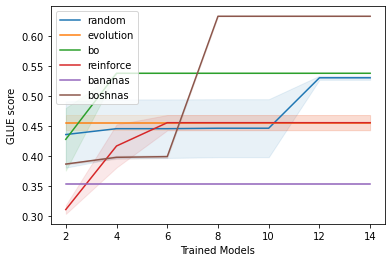

In [36]:
trained_models_interp = list(range(2, 16, 2))

fig, ax = plt.subplots()

for algo in algo_names:
    best_performances_algo = []
    for _ in range(2):
        trained_models, best_performances = run_nas_algorithm(algo, homogenous=False)
        best_performances_interp = np.interp(trained_models_interp, trained_models, best_performances)
        best_performances_algo.append(best_performances_interp)
    best_performances_algo = np.array(best_performances_algo)
    y = np.mean(best_performances_algo, axis=0)
    ci = 1.96 * np.std(best_performances_algo, axis=0) / y
    p = ax.plot(trained_models_interp, y, label=algo)
    ax.fill_between(trained_models_interp, (y-ci), (y+ci), color=p[0].get_color(), alpha=0.1)
        
plt.legend()
plt.xlabel('Trained Models')
plt.ylabel('GLUE score')
plt.show()